In [1]:
!pip install autofeat

In [33]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 19.0 MB/s eta 0:00:00


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from autofeat import AutoFeatRegressor, AutoFeatClassifier
import optuna
from sklearn.model_selection import KFold

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from re import template
train_label = pd.read_csv('/content/drive/MyDrive/Intellectra 2025/dataset/train_label_data.csv')
member = pd.read_csv('/content/drive/MyDrive/Intellectra 2025/dataset/member_data.csv')
train_transaction = pd.read_csv('/content/drive/MyDrive/Intellectra 2025/dataset/train_transaction_data.csv')
product = pd.read_csv('/content/drive/MyDrive/Intellectra 2025/dataset/product_data.csv')
program = pd.read_csv('/content/drive/MyDrive/Intellectra 2025/dataset/prodgram_data.csv')
test_transaction = pd.read_csv('/content/drive/MyDrive/Intellectra 2025/dataset/test_transaction_data.csv')
template_submission = pd.read_csv('/content/drive/MyDrive/Intellectra 2025/dataset/sample_submission.csv')

### Test

In [5]:
test = test_transaction.merge(member, on='MemberID', how='left')
test = test.merge(product, left_on='FK_PRODUCT_ID', right_on='productID', how='left')
test = test.merge(program, left_on='FK_PROD_GRAM_ID', right_on='prodgramID', how='left')

test

,TransactionID,MemberID,Source,FK_PRODUCT_ID,FK_PROD_GRAM_ID,Qty,PricePerUnit,TransactionDatetime,JoinDate,DateOfBirth,...,EldestKidDOB,YoungestKidDOB,productID,ProductName,ProductCategory,ProductLevel,prodgramID,GrammageName,Point,Price
0,5f57263c9b0b2b3e3d7c404510dd59060999115a,c2a630e3d0dc77dac0f63424a9ae1438,ALFAMART,27,52,1,165300.0,2020-07-01 06:09:00 UTC,2019-12-11,NaN,...,2018-07-04,2018-07-04,27,A,A,Original,52,700 GR,50,201000.0
1,b0c438ae346e794fef83c63a9ce17d6df73da233,3ecf7484c08418953e967a20de37051b,ALFAMART,27,52,1,165300.0,2020-07-01 10:13:00 UTC,2020-01-22,NaN,...,2018-12-21,2018-12-21,27,A,A,Original,52,700 GR,50,201000.0
2,7e2498fc518f0b1489982848a29dc2677ec31367,97bbd6c99a862f20657d9b2b1c77b2c8,ALFAMART,27,52,1,165300.0,2020-07-01 09:27:00 UTC,2019-01-02,1979-10-10,...,2017-10-19,2018-12-17,27,A,A,Original,52,700 GR,50,201000.0
3,aaa52daf4ca3b8befcbe01362d8219f67293bf45,3ce072ff9c6f2f4b7c95dbc08324a24d,INDOMARET,26,49,1,NaN,2020-07-01 11:04:00 UTC,2019-08-13,NaN,...,2017-06-17,2017-06-17,26,B,B,Original,49,400 GR,25,102000.0
4,4ec62459fb8d83062284e32f3c7b5af125d242b1,ab0b0de2a1c85a40b5d58644aef745c0,ALFAMART,26,49,2,85500.0,2020-07-01 09:24:00 UTC,2019-04-06,NaN,...,2010-06-18,2015-05-14,26,B,B,Original,49,400 GR,25,102000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21093,450fc2f9df98a733accf53dd8962bf2a0289b6b6,41dcc8b4aaf4eec5f9f574297f034f48,INDOMARET,22,39,1,288500.0,2021-06-30 09:46:00 UTC,2019-12-26,NaN,...,2018-11-11,2018-11-11,22,A G,A,Premium,39,900 GR,100,300000.0
21094,4c0a2e9e24915cfe35f46b79008eda815e7c4595,3959c14d6facdaf744872a9a82851d15,NATASHA,22,39,1,264000.0,2021-06-15 18:40:00 UTC,2020-11-16,NaN,...,2019-09-09,2019-09-09,22,A G,A,Premium,39,900 GR,100,300000.0
21095,10df5e2da431a4f27698503d627151821429a62f,2a475b583a848f184a3cb7dcd1a18556,BNS,22,39,1,285500.0,2021-06-29 13:32:00 UTC,2021-06-29,NaN,...,2020-05-31,2020-05-31,22,A G,A,Premium,39,900 GR,100,300000.0
21096,46e6822df9f04c0b073def722316ee2f622997dd,668e386666a44fd1821770a06be63a11,BUCHI KIDS,22,39,1,261700.0,2021-06-21 13:07:00 UTC,2013-08-21,2016-08-25,...,2011-10-30,2019-12-08,22,A G,A,Premium,39,900 GR,100,300000.0


In [6]:
test['Price'].value_counts()

,count
Price,
300000.0,12266
201000.0,5413
102000.0,3419


In [7]:
missing_values = test.isnull().sum()

missing_values = missing_values[missing_values > 0]

print("Missing values per kolom:")
print(missing_values)

Missing values per kolom:
PricePerUnit     3181
DateOfBirth     19840
dtype: int64


In [8]:
cols_to_drop = ['FK_PRODUCT_ID', 'productID', 'FK_PROD_GRAM_ID', 'prodgramID', 'TransactionID']
test = test.drop(columns=[col for col in cols_to_drop if col in test.columns])

test.head()

,MemberID,Source,Qty,PricePerUnit,TransactionDatetime,JoinDate,DateOfBirth,City,NoOfChild,EldestKidDOB,YoungestKidDOB,ProductName,ProductCategory,ProductLevel,GrammageName,Point,Price
0,c2a630e3d0dc77dac0f63424a9ae1438,ALFAMART,1,165300.0,2020-07-01 06:09:00 UTC,2019-12-11,NaN,MADIUN,1,2018-07-04,2018-07-04,A,A,Original,700 GR,50,201000.0
1,3ecf7484c08418953e967a20de37051b,ALFAMART,1,165300.0,2020-07-01 10:13:00 UTC,2020-01-22,NaN,KEBUMEN,1,2018-12-21,2018-12-21,A,A,Original,700 GR,50,201000.0
2,97bbd6c99a862f20657d9b2b1c77b2c8,ALFAMART,1,165300.0,2020-07-01 09:27:00 UTC,2019-01-02,1979-10-10,BOGOR,2,2017-10-19,2018-12-17,A,A,Original,700 GR,50,201000.0
3,3ce072ff9c6f2f4b7c95dbc08324a24d,INDOMARET,1,NaN,2020-07-01 11:04:00 UTC,2019-08-13,NaN,PALEMBANG,1,2017-06-17,2017-06-17,B,B,Original,400 GR,25,102000.0
4,ab0b0de2a1c85a40b5d58644aef745c0,ALFAMART,2,85500.0,2020-07-01 09:24:00 UTC,2019-04-06,NaN,SURABAYA,2,2010-06-18,2015-05-14,B,B,Original,400 GR,25,102000.0


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21098 entries, 0 to 21097
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MemberID             21098 non-null  object 
 1   Source               21098 non-null  object 
 2   Qty                  21098 non-null  int64  
 3   PricePerUnit         17917 non-null  float64
 4   TransactionDatetime  21098 non-null  object 
 5   JoinDate             21098 non-null  object 
 6   DateOfBirth          1258 non-null   object 
 7   City                 21098 non-null  object 
 8   NoOfChild            21098 non-null  int64  
 9   EldestKidDOB         21098 non-null  object 
 10  YoungestKidDOB       21098 non-null  object 
 11  ProductName          21098 non-null  object 
 12  ProductCategory      21098 non-null  object 
 13  ProductLevel         21098 non-null  object 
 14  GrammageName         21098 non-null  object 
 15  Point                21098 non-null 

In [10]:
test = test.drop(columns=['DateOfBirth'])

median_price = test['PricePerUnit'].median()
test['PricePerUnit'] = test['PricePerUnit'].fillna(median_price)

In [11]:
test['JoinDate'] = pd.to_datetime(test['JoinDate'])
test['TransactionDatetime'] = pd.to_datetime(test['TransactionDatetime'], utc=True).dt.tz_localize(None)

test['EldestKidDOB'] = pd.to_datetime(test['EldestKidDOB'], errors='coerce')
test['YoungestKidDOB'] = pd.to_datetime(test['YoungestKidDOB'], errors='coerce')

In [12]:
test.head()

,MemberID,Source,Qty,PricePerUnit,TransactionDatetime,JoinDate,City,NoOfChild,EldestKidDOB,YoungestKidDOB,ProductName,ProductCategory,ProductLevel,GrammageName,Point,Price
0,c2a630e3d0dc77dac0f63424a9ae1438,ALFAMART,1,165300.0,2020-07-01 06:09:00,2019-12-11,MADIUN,1,2018-07-04,2018-07-04,A,A,Original,700 GR,50,201000.0
1,3ecf7484c08418953e967a20de37051b,ALFAMART,1,165300.0,2020-07-01 10:13:00,2020-01-22,KEBUMEN,1,2018-12-21,2018-12-21,A,A,Original,700 GR,50,201000.0
2,97bbd6c99a862f20657d9b2b1c77b2c8,ALFAMART,1,165300.0,2020-07-01 09:27:00,2019-01-02,BOGOR,2,2017-10-19,2018-12-17,A,A,Original,700 GR,50,201000.0
3,3ce072ff9c6f2f4b7c95dbc08324a24d,INDOMARET,1,265000.0,2020-07-01 11:04:00,2019-08-13,PALEMBANG,1,2017-06-17,2017-06-17,B,B,Original,400 GR,25,102000.0
4,ab0b0de2a1c85a40b5d58644aef745c0,ALFAMART,2,85500.0,2020-07-01 09:24:00,2019-04-06,SURABAYA,2,2010-06-18,2015-05-14,B,B,Original,400 GR,25,102000.0


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21098 entries, 0 to 21097
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   MemberID             21098 non-null  object        
 1   Source               21098 non-null  object        
 2   Qty                  21098 non-null  int64         
 3   PricePerUnit         21098 non-null  float64       
 4   TransactionDatetime  21098 non-null  datetime64[ns]
 5   JoinDate             21098 non-null  datetime64[ns]
 6   City                 21098 non-null  object        
 7   NoOfChild            21098 non-null  int64         
 8   EldestKidDOB         21098 non-null  datetime64[ns]
 9   YoungestKidDOB       21098 non-null  datetime64[ns]
 10  ProductName          21098 non-null  object        
 11  ProductCategory      21098 non-null  object        
 12  ProductLevel         21098 non-null  object        
 13  GrammageName         21098 non-

In [14]:
test['Trans_Year']     = test['TransactionDatetime'].dt.year
test['Trans_Month']    = test['TransactionDatetime'].dt.month
test['Trans_Day']      = test['TransactionDatetime'].dt.day
test['Trans_Weekday']  = test['TransactionDatetime'].dt.weekday   # 0=Senin, 6=Minggu
test['Trans_Hour']     = test['TransactionDatetime'].dt.hour
test['IsWeekend'] = test['Trans_Weekday'].isin([5, 6]).astype(int)

test['Days_Since_Join'] = (test['TransactionDatetime'] - test['JoinDate']).dt.days

# ======= JoinDate =======
test['Join_Year']     = test['JoinDate'].dt.year
test['Join_Month']    = test['JoinDate'].dt.month
test['Join_Weekday']  = test['JoinDate'].dt.weekday  # 0=Senin
test['Join_Day']      = test['JoinDate'].dt.day

# ======= EldestKidDOB =======
test['EldestKid_Year']    = test['EldestKidDOB'].dt.year
test['EldestKid_Month']   = test['EldestKidDOB'].dt.month
test['EldestKid_AgeDays'] = (test['TransactionDatetime'] - test['EldestKidDOB']).dt.days
test['EldestKid_AgeYears'] = test['EldestKid_AgeDays'] / 365

# ======= YoungestKidDOB =======
test['YoungestKid_Year']    = test['YoungestKidDOB'].dt.year
test['YoungestKid_Month']   = test['YoungestKidDOB'].dt.month
test['YoungestKid_AgeDays'] = (test['TransactionDatetime'] - test['YoungestKidDOB']).dt.days
test['YoungestKid_AgeYears'] = test['YoungestKid_AgeDays'] / 365

In [15]:
test = test.drop(columns=['JoinDate', 'EldestKidDOB', 'YoungestKidDOB', 'TransactionDatetime'])

In [16]:
# Pastikan fitur biner benar-benar integer
test['IsWeekend'] = test['IsWeekend'].astype(int)

# Jika yakin AgeDays tidak mengandung NaN, bisa juga ubah ke int
test['EldestKid_AgeDays'] = test['EldestKid_AgeDays'].astype(int)
test['YoungestKid_AgeDays'] = test['YoungestKid_AgeDays'].astype(int)

In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21098 entries, 0 to 21097
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MemberID              21098 non-null  object 
 1   Source                21098 non-null  object 
 2   Qty                   21098 non-null  int64  
 3   PricePerUnit          21098 non-null  float64
 4   City                  21098 non-null  object 
 5   NoOfChild             21098 non-null  int64  
 6   ProductName           21098 non-null  object 
 7   ProductCategory       21098 non-null  object 
 8   ProductLevel          21098 non-null  object 
 9   GrammageName          21098 non-null  object 
 10  Point                 21098 non-null  int64  
 11  Price                 21098 non-null  float64
 12  Trans_Year            21098 non-null  int32  
 13  Trans_Month           21098 non-null  int32  
 14  Trans_Day             21098 non-null  int32  
 15  Trans_Weekday      

In [18]:
data_test = test.drop(columns=['MemberID'])

In [19]:
categorical_cols = ['City', 'Source', 'ProductName', 'ProductCategory', 'ProductLevel', 'GrammageName']

le = LabelEncoder()
for col in categorical_cols:
    data_test[col] = le.fit_transform(data_test[col])

In [20]:
int32_cols = data_test.select_dtypes('int32').columns
data_test[int32_cols] = data_test[int32_cols].astype('int64')

scaler = StandardScaler()
cols_to_scale = ['PricePerUnit', 'Price', 'EldestKid_AgeYears', 'YoungestKid_AgeYears']
data_test[cols_to_scale] = scaler.fit_transform(data_test[cols_to_scale])

In [21]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21098 entries, 0 to 21097
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Source                21098 non-null  int64  
 1   Qty                   21098 non-null  int64  
 2   PricePerUnit          21098 non-null  float64
 3   City                  21098 non-null  int64  
 4   NoOfChild             21098 non-null  int64  
 5   ProductName           21098 non-null  int64  
 6   ProductCategory       21098 non-null  int64  
 7   ProductLevel          21098 non-null  int64  
 8   GrammageName          21098 non-null  int64  
 9   Point                 21098 non-null  int64  
 10  Price                 21098 non-null  float64
 11  Trans_Year            21098 non-null  int64  
 12  Trans_Month           21098 non-null  int64  
 13  Trans_Day             21098 non-null  int64  
 14  Trans_Weekday         21098 non-null  int64  
 15  Trans_Hour         

### Train

In [ ]:
train = train_label.merge(member, on='MemberID', how='left')
train = train.merge(train_transaction, on='MemberID', how='left')
train = train.merge(product, left_on='FK_PRODUCT_ID', right_on='productID', how='left')
train = train.merge(program, left_on='FK_PROD_GRAM_ID', right_on='prodgramID', how='left')

train

,MemberID,next_buy,JoinDate,DateOfBirth,City,NoOfChild,EldestKidDOB,YoungestKidDOB,TransactionID,Source,...,PricePerUnit,TransactionDatetime,productID,ProductName,ProductCategory,ProductLevel,prodgramID,GrammageName,Point,Price
0,7ef72aa51aecb701dc5c4074480fcdf6,0,2019-12-24,NaN,BEKASI,1,2017-07-31,2017-07-31,ffd6c035bef03a2c386caf2552148fb2402b0b24,ELANG,...,NaN,2020-07-01 07:41:00 UTC,27,A,A,Original,52,700 GR,50,201000.0
1,7ef72aa51aecb701dc5c4074480fcdf6,0,2019-12-24,NaN,BEKASI,1,2017-07-31,2017-07-31,2d44fc3bc51dcec02195d710608946b751fec454,ELANG,...,155000.0,2020-07-19 19:17:00 UTC,27,A,A,Original,52,700 GR,50,201000.0
2,7ef72aa51aecb701dc5c4074480fcdf6,0,2019-12-24,NaN,BEKASI,1,2017-07-31,2017-07-31,8b398107bc1b80536ff1c17dd782e24a8412938d,GRAND MART,...,156000.0,2020-07-23 17:26:00 UTC,27,A,A,Original,52,700 GR,50,201000.0
3,7ef72aa51aecb701dc5c4074480fcdf6,0,2019-12-24,NaN,BEKASI,1,2017-07-31,2017-07-31,ad47258d69724c1011ccc14e5df93130315317dd,ELANG,...,155000.0,2020-08-04 18:30:00 UTC,27,A,A,Original,52,700 GR,50,201000.0
4,7ef72aa51aecb701dc5c4074480fcdf6,0,2019-12-24,NaN,BEKASI,1,2017-07-31,2017-07-31,5ae6475339484e73adddfb2ff257071b7b85a708,ELANG,...,185000.0,2020-10-05 18:12:00 UTC,27,A,A,Original,52,700 GR,50,201000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130849,315f1713abdba2f787d88c503c1a09b2,0,2020-12-08,NaN,KARAWANG,1,2019-11-28,2019-11-28,c4328f49e0fe8ac72139de63b221a12119252c74,SUSU MURAH,...,NaN,2021-06-30 14:05:00 UTC,22,A G,A,Premium,39,900 GR,100,300000.0
130850,b6487d0c08326c109670ffc663fc0114,0,2016-06-22,2017-01-02,TANGERANG,2,2013-03-07,2019-06-04,d5c6975e75a6ff6eb014d94e6c4badaac3e0e99d,NATASHA,...,264000.0,2021-06-30 12:40:00 UTC,22,A G,A,Premium,39,900 GR,100,300000.0
130851,23c160a43517f7cd01aa43297064efad,0,2021-02-01,NaN,PALU,1,2019-09-19,2019-09-19,73d84c4b8bbf2f9a4a2bf55a98eba5c2ff8518bb,GRAND HERO PALU,...,287200.0,2021-06-30 13:06:00 UTC,22,A G,A,Premium,39,900 GR,100,300000.0
130852,c9a2a250ee2ba87120094365759e4787,0,2020-03-11,NaN,MADIUN,1,2018-09-06,2018-09-06,5f22d8dab29b2df38877c3e4dcc6257da1f114fc,EDISAN,...,265000.0,2021-06-30 14:45:00 UTC,22,A G,A,Premium,39,900 GR,100,300000.0


In [ ]:
columns_to_drop = ['FK_PRODUCT_ID', 'productID', 'FK_PROD_GRAM_ID', 'prodgramID', 'TransactionID']
train = train.drop(columns=columns_to_drop)

train.head()

,MemberID,next_buy,JoinDate,DateOfBirth,City,NoOfChild,EldestKidDOB,YoungestKidDOB,Source,Qty,PricePerUnit,TransactionDatetime,ProductName,ProductCategory,ProductLevel,GrammageName,Point,Price
0,7ef72aa51aecb701dc5c4074480fcdf6,0,2019-12-24,NaN,BEKASI,1,2017-07-31,2017-07-31,ELANG,1,NaN,2020-07-01 07:41:00 UTC,A,A,Original,700 GR,50,201000.0
1,7ef72aa51aecb701dc5c4074480fcdf6,0,2019-12-24,NaN,BEKASI,1,2017-07-31,2017-07-31,ELANG,1,155000.0,2020-07-19 19:17:00 UTC,A,A,Original,700 GR,50,201000.0
2,7ef72aa51aecb701dc5c4074480fcdf6,0,2019-12-24,NaN,BEKASI,1,2017-07-31,2017-07-31,GRAND MART,1,156000.0,2020-07-23 17:26:00 UTC,A,A,Original,700 GR,50,201000.0
3,7ef72aa51aecb701dc5c4074480fcdf6,0,2019-12-24,NaN,BEKASI,1,2017-07-31,2017-07-31,ELANG,1,155000.0,2020-08-04 18:30:00 UTC,A,A,Original,700 GR,50,201000.0
4,7ef72aa51aecb701dc5c4074480fcdf6,0,2019-12-24,NaN,BEKASI,1,2017-07-31,2017-07-31,ELANG,1,185000.0,2020-10-05 18:12:00 UTC,A,A,Original,700 GR,50,201000.0


In [ ]:
train['Price'].value_counts()

,count
Price,
300000.0,77022
201000.0,35109
102000.0,18723


In [ ]:
missing_values = train.isnull().sum()

missing_values = missing_values[missing_values > 0]

print("Missing values per kolom:")
print(missing_values)

Missing values per kolom:
DateOfBirth     124162
PricePerUnit     19173
dtype: int64


In [ ]:
train = train.drop(columns=['DateOfBirth'])

median_price = train['PricePerUnit'].median()
train['PricePerUnit'] = train['PricePerUnit'].fillna(median_price)

In [ ]:
train['JoinDate'] = pd.to_datetime(train['JoinDate'])
train['TransactionDatetime'] = pd.to_datetime(train['TransactionDatetime'], utc=True).dt.tz_localize(None)

train['EldestKidDOB'] = pd.to_datetime(train['EldestKidDOB'], errors='coerce')
train['YoungestKidDOB'] = pd.to_datetime(train['YoungestKidDOB'], errors='coerce')

In [ ]:
train.head()

,MemberID,next_buy,JoinDate,City,NoOfChild,EldestKidDOB,YoungestKidDOB,Source,Qty,PricePerUnit,TransactionDatetime,ProductName,ProductCategory,ProductLevel,GrammageName,Point,Price
0,7ef72aa51aecb701dc5c4074480fcdf6,0,2019-12-24,BEKASI,1,2017-07-31,2017-07-31,ELANG,1,265000.0,2020-07-01 07:41:00,A,A,Original,700 GR,50,201000.0
1,7ef72aa51aecb701dc5c4074480fcdf6,0,2019-12-24,BEKASI,1,2017-07-31,2017-07-31,ELANG,1,155000.0,2020-07-19 19:17:00,A,A,Original,700 GR,50,201000.0
2,7ef72aa51aecb701dc5c4074480fcdf6,0,2019-12-24,BEKASI,1,2017-07-31,2017-07-31,GRAND MART,1,156000.0,2020-07-23 17:26:00,A,A,Original,700 GR,50,201000.0
3,7ef72aa51aecb701dc5c4074480fcdf6,0,2019-12-24,BEKASI,1,2017-07-31,2017-07-31,ELANG,1,155000.0,2020-08-04 18:30:00,A,A,Original,700 GR,50,201000.0
4,7ef72aa51aecb701dc5c4074480fcdf6,0,2019-12-24,BEKASI,1,2017-07-31,2017-07-31,ELANG,1,185000.0,2020-10-05 18:12:00,A,A,Original,700 GR,50,201000.0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130854 entries, 0 to 130853
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   MemberID             130854 non-null  object        
 1   next_buy             130854 non-null  int64         
 2   JoinDate             130854 non-null  datetime64[ns]
 3   City                 130854 non-null  object        
 4   NoOfChild            130854 non-null  int64         
 5   EldestKidDOB         130854 non-null  datetime64[ns]
 6   YoungestKidDOB       130854 non-null  datetime64[ns]
 7   Source               130854 non-null  object        
 8   Qty                  130854 non-null  int64         
 9   PricePerUnit         130854 non-null  float64       
 10  TransactionDatetime  130854 non-null  datetime64[ns]
 11  ProductName          130854 non-null  object        
 12  ProductCategory      130854 non-null  object        
 13  ProductLevel  

In [ ]:
train['Trans_Year']     = train['TransactionDatetime'].dt.year
train['Trans_Month']    = train['TransactionDatetime'].dt.month
train['Trans_Day']      = train['TransactionDatetime'].dt.day
train['Trans_Weekday']  = train['TransactionDatetime'].dt.weekday   # 0=Senin, 6=Minggu
train['Trans_Hour']     = train['TransactionDatetime'].dt.hour
train['IsWeekend'] = train['Trans_Weekday'].isin([5, 6]).astype(int)

train['Days_Since_Join'] = (train['TransactionDatetime'] - train['JoinDate']).dt.days

# ======= JoinDate =======
train['Join_Year']     = train['JoinDate'].dt.year
train['Join_Month']    = train['JoinDate'].dt.month
train['Join_Weekday']  = train['JoinDate'].dt.weekday  # 0=Senin
train['Join_Day']      = train['JoinDate'].dt.day

# ======= EldestKidDOB =======
train['EldestKid_Year']    = train['EldestKidDOB'].dt.year
train['EldestKid_Month']   = train['EldestKidDOB'].dt.month
train['EldestKid_AgeDays'] = (train['TransactionDatetime'] - train['EldestKidDOB']).dt.days
train['EldestKid_AgeYears'] = train['EldestKid_AgeDays'] / 365

# ======= YoungestKidDOB =======
train['YoungestKid_Year']    = train['YoungestKidDOB'].dt.year
train['YoungestKid_Month']   = train['YoungestKidDOB'].dt.month
train['YoungestKid_AgeDays'] = (train['TransactionDatetime'] - train['YoungestKidDOB']).dt.days
train['YoungestKid_AgeYears'] = train['YoungestKid_AgeDays'] / 365

In [ ]:
train = train.drop(columns=['JoinDate', 'EldestKidDOB', 'YoungestKidDOB', 'TransactionDatetime'])

In [ ]:
# Pastikan fitur biner benar-benar integer
train['IsWeekend'] = train['IsWeekend'].astype(int)

# Jika yakin AgeDays tidak mengandung NaN, bisa juga ubah ke int
train['EldestKid_AgeDays'] = train['EldestKid_AgeDays'].astype(int)
train['YoungestKid_AgeDays'] = train['YoungestKid_AgeDays'].astype(int)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130854 entries, 0 to 130853
Data columns (total 32 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   MemberID              130854 non-null  object 
 1   next_buy              130854 non-null  int64  
 2   City                  130854 non-null  object 
 3   NoOfChild             130854 non-null  int64  
 4   Source                130854 non-null  object 
 5   Qty                   130854 non-null  int64  
 6   PricePerUnit          130854 non-null  float64
 7   ProductName           130854 non-null  object 
 8   ProductCategory       130854 non-null  object 
 9   ProductLevel          130854 non-null  object 
 10  GrammageName          130854 non-null  object 
 11  Point                 130854 non-null  int64  
 12  Price                 130854 non-null  float64
 13  Trans_Year            130854 non-null  int32  
 14  Trans_Month           130854 non-null  int32  
 15  

In [ ]:
data_train = train.drop(columns=['MemberID'])

In [ ]:
categorical_cols = ['City', 'Source', 'ProductName', 'ProductCategory', 'ProductLevel', 'GrammageName']

le = LabelEncoder()
for col in categorical_cols:
    data_train[col] = le.fit_transform(data_train[col])

In [ ]:
int32_cols = data_train.select_dtypes('int32').columns
data_train[int32_cols] = data_train[int32_cols].astype('int64')

scaler = StandardScaler()
cols_to_scale = ['PricePerUnit', 'Price', 'EldestKid_AgeYears', 'YoungestKid_AgeYears']
data_train[cols_to_scale] = scaler.fit_transform(data_train[cols_to_scale])

In [ ]:
# Cek apakah hasil scaling sesuai
data_train[cols_to_scale].head()

,PricePerUnit,Price,EldestKid_AgeYears,YoungestKid_AgeYears
0,0.566443,-0.61014,0.085452,0.433446
1,-0.966239,-0.61014,0.111878,0.470071
2,-0.952306,-0.61014,0.117750,0.478210
3,-0.966239,-0.61014,0.135367,0.502627
4,-0.548235,-0.61014,0.226390,0.628781


In [ ]:
data_train['Price'].value_counts()

,count
Price,
0.759339,77022
-0.610140,35109
-1.979619,18723


In [ ]:
print(data_train.dtypes.value_counts())
print(data_train.describe())

int64      27
float64     4
Name: count, dtype: int64
            next_buy           City      NoOfChild         Source  \
count  130854.000000  130854.000000  130854.000000  130854.000000   
mean        0.178015     204.803713       1.246657     565.198274   
std         0.382527     123.988923       0.600406     382.080683   
min         0.000000       0.000000       1.000000       0.000000   
25%         0.000000     102.000000       1.000000     241.000000   
50%         0.000000     213.000000       1.000000     548.000000   
75%         0.000000     314.000000       1.000000     888.000000   
max         1.000000     426.000000       8.000000    1365.000000   

                 Qty  PricePerUnit    ProductName  ProductCategory  \
count  130854.000000  1.308540e+05  130854.000000    130854.000000   
mean        1.353745 -1.529100e-16       0.875457         0.143335   
std         0.918298  1.000004e+00       0.630471         0.350416   
min         1.000000 -2.652189e+00       0.0

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130854 entries, 0 to 130853
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   next_buy              130854 non-null  int64  
 1   City                  130854 non-null  int64  
 2   NoOfChild             130854 non-null  int64  
 3   Source                130854 non-null  int64  
 4   Qty                   130854 non-null  int64  
 5   PricePerUnit          130854 non-null  float64
 6   ProductName           130854 non-null  int64  
 7   ProductCategory       130854 non-null  int64  
 8   ProductLevel          130854 non-null  int64  
 9   GrammageName          130854 non-null  int64  
 10  Point                 130854 non-null  int64  
 11  Price                 130854 non-null  float64
 12  Trans_Year            130854 non-null  int64  
 13  Trans_Month           130854 non-null  int64  
 14  Trans_Day             130854 non-null  int64  
 15  

In [ ]:
data_train.to_csv('data_train.csv', index=False)

from google.colab import files
files.download('data_train.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
data_test.to_csv('data_test.csv', index=False)

from google.colab import files
files.download('data_test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### By-pass data

In [22]:
data_train = pd.read_csv('/content/drive/MyDrive/Intellectra 2025/dataset/data_train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/Intellectra 2025/dataset/data_test.csv')

In [23]:
data_train_feat = pd.read_csv('/content/drive/MyDrive/Intellectra 2025/dataset/data_train_feat.csv')
data_test_feat = pd.read_csv('/content/drive/MyDrive/Intellectra 2025/dataset/data_test_feat.csv')

### Ope

**Auto Feature Engineering**

In [ ]:
# X = data_train.drop(columns=['next_buy'])
# y = data_train['next_buy']

# autofeat = AutoFeatClassifier(verbose=1, feateng_steps=1)
# X_feat = autofeat.fit_transform(X, y)

# data_train_feat = X_feat.copy()
# data_train_feat['next_buy'] = y.values

# #-------------------------------------------------------------



In [8]:
# original_columns = X.columns.tolist()

# X_test = data_test[original_columns]

In [9]:
# X_feat_test = autofeat.transform(X_test)

# data_test_feat = X_feat_test.copy()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [6]:
# data_train_feat.to_csv('data_train_feat.csv', index=False)

# from google.colab import files
# files.download('data_train_feat.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# data_test_feat.to_csv('data_test_feat.csv', index=False)

# from google.colab import files
# files.download('data_test_feat.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
if list((data_train_feat.drop(columns=['next_buy'])).columns) == list(data_test_feat.columns):
    print("Kolom train dan test sudah sama persis (nama & urutan).")
else:
    print("Kolom tidak sama atau urutannya berbeda.")

Kolom train dan test sudah sama persis (nama & urutan).


In [25]:
data_train_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130854 entries, 0 to 130853
Data columns (total 50 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   City                       130854 non-null  float64
 1   NoOfChild                  130854 non-null  float64
 2   Source                     130854 non-null  float64
 3   Qty                        130854 non-null  float64
 4   PricePerUnit               130854 non-null  float64
 5   ProductName                130854 non-null  float64
 6   ProductCategory            130854 non-null  float64
 7   ProductLevel               130854 non-null  float64
 8   GrammageName               130854 non-null  float64
 9   Point                      130854 non-null  float64
 10  Price                      130854 non-null  float64
 11  Trans_Year                 130854 non-null  float64
 12  Trans_Month                130854 non-null  float64
 13  Trans_Day                  13

In [26]:
data_test_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21098 entries, 0 to 21097
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   City                       21098 non-null  float64
 1   NoOfChild                  21098 non-null  float64
 2   Source                     21098 non-null  float64
 3   Qty                        21098 non-null  float64
 4   PricePerUnit               21098 non-null  float64
 5   ProductName                21098 non-null  float64
 6   ProductCategory            21098 non-null  float64
 7   ProductLevel               21098 non-null  float64
 8   GrammageName               21098 non-null  float64
 9   Point                      21098 non-null  float64
 10  Price                      21098 non-null  float64
 11  Trans_Year                 21098 non-null  float64
 12  Trans_Month                21098 non-null  float64
 13  Trans_Day                  21098 non-null  flo

**Correlation check**

Top 20 Fitur Penting:
Days_Since_Join              0.052295
City                         0.051797
Days_Since_Join**2           0.051777
Source                       0.040935
PricePerUnit                 0.037036
1/Join_Day                   0.036797
Join_Day                     0.036739
Abs(PricePerUnit)            0.033259
PricePerUnit**2              0.029854
YoungestKid_AgeDays          0.024850
exp(YoungestKid_AgeYears)    0.024459
YoungestKid_AgeDays**3       0.024234
Abs(EldestKid_AgeYears)      0.023606
YoungestKid_AgeYears         0.023526
Point                        0.023018
Price                        0.022979
Trans_Hour                   0.022893
Trans_Month                  0.022674
GrammageName                 0.022291
1/Trans_Month                0.022251
dtype: float64


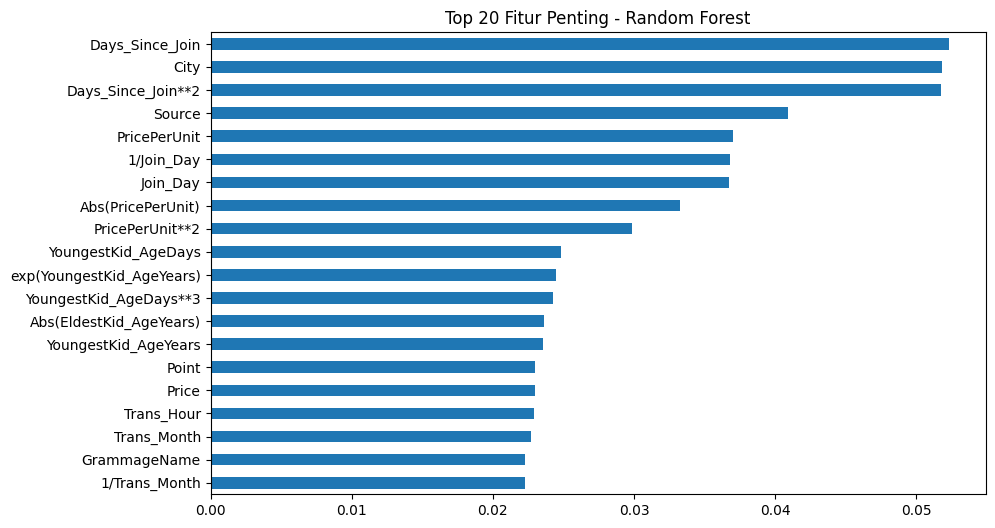

In [27]:
# Tentukan target
target_col = 'next_buy'
X = data_train_feat.drop(columns=[target_col])
y = data_train_feat[target_col]

# Deteksi kolom string (object)
non_numeric_cols = X.select_dtypes(include=['object', 'string']).columns.tolist()

# Drop kolom ID unik dan high-cardinality (>100)
id_like_cols = [col for col in non_numeric_cols if X[col].nunique() == X.shape[0]]
high_card_cols = [col for col in non_numeric_cols if X[col].nunique() > 100]
drop_cols = list(set(id_like_cols + high_card_cols))
X_reduced = X.drop(columns=drop_cols)

# Label encoding kolom kategorikal sisanya
for col in X_reduced.select_dtypes(include=['object', 'string']).columns:
    le = LabelEncoder()
    X_reduced[col] = le.fit_transform(X_reduced[col].astype(str))

# Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_reduced, y)

# Feature importance
importances = pd.Series(model.feature_importances_, index=X_reduced.columns).sort_values(ascending=False)

# Tampilkan top 20
print("Top 20 Fitur Penting:")
print(importances.head(20))

# Visualisasi
importances.head(20).plot(kind='barh', figsize=(10, 6))
plt.title("Top 20 Fitur Penting - Random Forest")
plt.gca().invert_yaxis()
plt.show()

**Imbalanced Handle and Feature Engineering**

next_buy
0    107560
1     23294
Name: count, dtype: int64
next_buy
0    0.821985
1    0.178015
Name: proportion, dtype: float64
Rasio kelas minoritas terhadap mayoritas: 0.21656749721085905


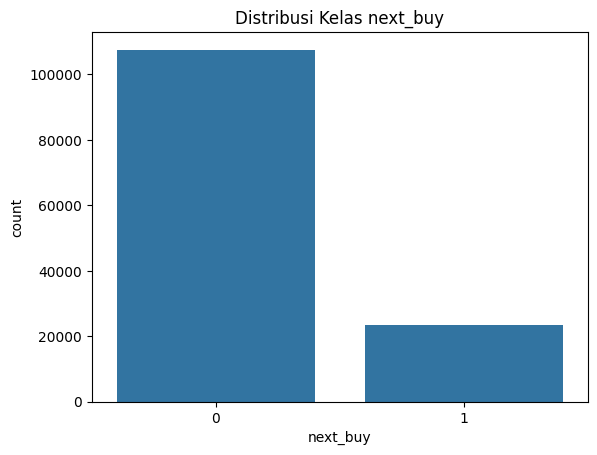

In [28]:
print(data_train_feat['next_buy'].value_counts())
print(data_train_feat['next_buy'].value_counts(normalize=True))

counts = data_train_feat['next_buy'].value_counts()
imbalance_ratio = counts.min() / counts.max()
print("Rasio kelas minoritas terhadap mayoritas:", imbalance_ratio)

sns.countplot(x='next_buy', data=data_train_feat)
plt.title('Distribusi Kelas next_buy')
plt.show()

**Model Selection and Training**

In [29]:
X = data_train_feat.drop(columns=['next_buy'])
y = data_train_feat['next_buy']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [30]:
from collections import Counter

def show_distribution(y, name=""):
    counts = Counter(y)
    total = sum(counts.values())
    for k, v in counts.items():
        print(f"{name} - Class {k}: {v} ({v/total:.2%})")

show_distribution(y_train, "Train")
show_distribution(y_valid, "Valid")

Train - Class 0: 86048 (82.20%)
Train - Class 1: 18635 (17.80%)
Valid - Class 0: 21512 (82.20%)
Valid - Class 1: 4659 (17.80%)


In [31]:
from collections import Counter
print("Sebelum balancing:", Counter(y_train))

Sebelum balancing: Counter({0: 86048, 1: 18635})


In [32]:
# Inisialisasi SMOTE + TomekLinks
smote_tomek = SMOTETomek(random_state=42)

# Fit hanya ke data train
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

# Cek hasil balancing
from collections import Counter
print("Setelah SMOTETomek:", Counter(y_train_resampled))

Setelah SMOTETomek: Counter({0: 76281, 1: 76281})


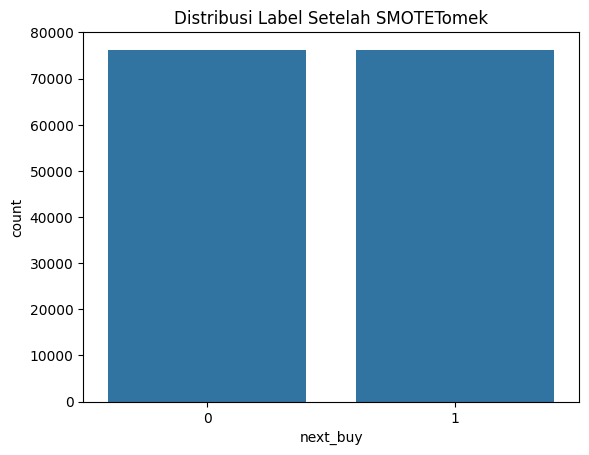

In [35]:
sns.countplot(x=y_train_resampled)
plt.title("Distribusi Label Setelah SMOTETomek")
plt.show()

In [40]:
def objective(trial):
    max_depth = trial.suggest_int("max_depth", 3, 8)
    max_leaves = min(200, 2 ** max_depth)
    min_leaves = min(max_leaves, 2 ** (max_depth - 1))

    param = {
        "objective": "binary",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 42,
        "n_jobs": -1,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", min_leaves, max_leaves),
        "max_depth": max_depth,
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 5.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 5.0, log=True),
        "scale_pos_weight": scale_pos_weight,  # gunakan ini jika datamu imbalance
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    balanced_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_resampled)):
        X_tr, X_val_ = X_train_resampled.iloc[train_idx], X_train_resampled.iloc[val_idx]
        y_tr, y_val_ = y_train_resampled.iloc[train_idx], y_train_resampled.iloc[val_idx]

        model = lgb.LGBMClassifier(
            n_estimators=1000,
            **param
        )

        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val_, y_val_)],
            eval_metric="binary_logloss",  # tidak ngaruh karena kita hitung manual
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
        )

        y_pred = model.predict(X_val_)
        bal_acc = balanced_accuracy_score(y_val_, y_pred)
        print(f"Fold {fold+1} Balanced Accuracy: {bal_acc:.4f}")
        balanced_scores.append(bal_acc)

    return np.mean(balanced_scores)

In [42]:
neg, pos = np.bincount(y_train_resampled)
scale_pos_weight = neg / pos

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2025-07-03 07:53:43,876] A new study created in memory with name: no-name-2dc697ff-682e-44d6-b7f8-5af9463f74cd


  0%|          | 0/100 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[964]	valid_0's binary_logloss: 0.0733249
Fold 1 Balanced Accuracy: 0.9757
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's binary_logloss: 0.0744196
Fold 2 Balanced Accuracy: 0.9744
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's binary_logloss: 0.0676719
Fold 3 Balanced Accuracy: 0.9771
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.074674
Fold 4 Balanced Accuracy: 0.9749
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's binary_logloss: 0.0733549
Fold 5 Balanced Accuracy: 0.9755
[I 2025-07-03 07:59:18,432] Trial 0 finished with value: 0.9755258994779064 and 

In [49]:
import json

with open("best_lgbm_params.json", "w") as f:
    json.dump(study.best_trial.params, f)

from google.colab import files
files.download("best_lgbm_params.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
print("Best trial:")
print("  Balanced Accuracy:", study.best_value)
print("  Best Params:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")

Best trial:
  Balanced Accuracy: 0.977335948071938
  Best Params:
    max_depth: 8
    learning_rate: 0.11121953978117204
    num_leaves: 180
    min_child_samples: 14
    feature_fraction: 0.7638534015714536
    bagging_fraction: 0.9887600352493008
    bagging_freq: 1
    reg_alpha: 6.877703840177225e-08
    reg_lambda: 0.012527361140179216


In [44]:
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, confusion_matrix

def evaluate_model(name, model, X_train, y_train, X_val, y_val):
    print(f"\n=== {name} ===")

    def evaluate_split(split_name, X, y):
        y_pred = model.predict(X)
        y_prob = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else None

        f1 = f1_score(y, y_pred)
        bal_acc = balanced_accuracy_score(y, y_pred)
        auc = roc_auc_score(y, y_prob) if y_prob is not None else "N/A"

        print(f"\n--- {split_name} ---")
        print("F1 Score          :", round(f1, 4))
        print("Balanced Accuracy :", round(bal_acc, 4))
        print("AUC Score         :", round(auc, 4) if auc != "N/A" else "N/A")
        print("Confusion Matrix:\n", confusion_matrix(y, y_pred))

    evaluate_split("Train", X_train, y_train)
    evaluate_split("Validation/Test", X_val, y_val)

In [45]:
# Gabungkan best_params dengan setting tetap
best_params = study.best_params
best_params.update({
    "objective": "binary",
    "random_state": 42,
    "scale_pos_weight": scale_pos_weight,
    "n_jobs": -1
})

# Fit model final
best_lgb_model = lgb.LGBMClassifier(
    n_estimators=1000,
    **best_params
)

best_lgb_model.fit(X_train_resampled, y_train_resampled,
                   eval_set=[(X_valid, y_valid)],
                   eval_metric="binary_logloss",
                   callbacks=[lgb.early_stopping(50), lgb.log_evaluation(10)])
evaluate_model("LightGBM (Optuna Tuned)", best_lgb_model, X_train_resampled, y_train_resampled, X_valid, y_valid)

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.425115
[20]	valid_0's binary_logloss: 0.356913
[30]	valid_0's binary_logloss: 0.327699
[40]	valid_0's binary_logloss: 0.313805
[50]	valid_0's binary_logloss: 0.303026
[60]	valid_0's binary_logloss: 0.293012
[70]	valid_0's binary_logloss: 0.281455
[80]	valid_0's binary_logloss: 0.269561
[90]	valid_0's binary_logloss: 0.260256
[100]	valid_0's binary_logloss: 0.253704
[110]	valid_0's binary_logloss: 0.24459
[120]	valid_0's binary_logloss: 0.238383
[130]	valid_0's binary_logloss: 0.232714
[140]	valid_0's binary_logloss: 0.227524
[150]	valid_0's binary_logloss: 0.221409
[160]	valid_0's binary_logloss: 0.215285
[170]	valid_0's binary_logloss: 0.210932
[180]	valid_0's binary_logloss: 0.204747
[190]	valid_0's binary_logloss: 0.200755
[200]	valid_0's binary_logloss: 0.1978
[210]	valid_0's binary_logloss: 0.193532
[220]	valid_0's binary_logloss: 0.189999
[230]	valid_0's binary_logloss: 0.186138
[240]	va

In [50]:
import joblib

joblib.dump(best_lgb_model, "best_lgb_model_1.pkl")

from google.colab import files
files.download("best_lgb_model_1.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
# Hitung rasio kelas negatif : positif untuk LightGBM
neg, pos = np.bincount(y_train_resampled)
scale_pos_weight = neg / pos

# 1. Logistic Regression dengan class_weight='balanced'
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg.fit(X_train_resampled, y_train_resampled)
evaluate_model("Logistic Regression", logreg, X_train_resampled, y_train_resampled, X_valid, y_valid)

# 2. Random Forest dengan class_weight='balanced'
rf = RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced')
rf.fit(X_train_resampled, y_train_resampled)
evaluate_model("Random Forest", rf, X_train_resampled, y_train_resampled, X_valid, y_valid)

# 3. LightGBM dengan scale_pos_weight
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42,
                               scale_pos_weight=scale_pos_weight)
lgb_model.fit(X_train_resampled, y_train_resampled)
evaluate_model("LightGBM", lgb_model, X_train_resampled, y_train_resampled, X_valid, y_valid)


=== Logistic Regression ===

--- Train ---
F1 Score          : 0.0078
Balanced Accuracy : 0.5
AUC Score         : 0.6089
Confusion Matrix:
 [[75978   303]
 [75980   301]]

--- Validation/Test ---
F1 Score          : 0.0076
Balanced Accuracy : 0.5
AUC Score         : 0.5966
Confusion Matrix:
 [[21428    84]
 [ 4641    18]]

=== Random Forest ===

--- Train ---
F1 Score          : 1.0
Balanced Accuracy : 1.0
AUC Score         : 1.0
Confusion Matrix:
 [[76281     0]
 [    7 76274]]

--- Validation/Test ---
F1 Score          : 0.6952
Balanced Accuracy : 0.8
AUC Score         : 0.9338
Confusion Matrix:
 [[20521   991]
 [ 1649  3010]]
[LightGBM] [Info] Number of positive: 76281, number of negative: 76281
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12473
[LightGBM] [Info] Number of da

**Ensemble Manual**

In [48]:
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, confusion_matrix

def evaluate_manual_ensemble(name, y_train, y_prob_train, y_val, y_prob_val, threshold=0.5):
    print(f"\n=== {name} ===")

    def eval_split(split_name, y_true, y_prob):
        y_pred = (y_prob >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        bal_acc = balanced_accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_prob)

        print(f"\n--- {split_name} ---")
        print("F1 Score          :", round(f1, 4))
        print("Balanced Accuracy :", round(bal_acc, 4))
        print("AUC Score         :", round(auc, 4))
        print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

    eval_split("Train", y_train, y_prob_train)
    eval_split("Validation/Test", y_val, y_prob_val)

In [49]:
# Gabungkan probabilitas (misal rata-rata)
y_prob_train_rf = rf.predict_proba(X_train_resampled)[:, 1]
y_prob_train_lgb = lgb_model.predict_proba(X_train_resampled)[:, 1]
y_prob_train_avg = (y_prob_train_rf + y_prob_train_lgb) / 2

y_prob_val_rf = rf.predict_proba(X_valid)[:, 1]
y_prob_val_lgb = lgb_model.predict_proba(X_valid)[:, 1]
y_prob_val_avg = (y_prob_val_rf + y_prob_val_lgb) / 2

# Evaluasi ensemble manual
evaluate_manual_ensemble(
    "Manual Ensemble (avg)",
    y_train_resampled, y_prob_train_avg,
    y_valid, y_prob_val_avg,
    threshold=0.5  # bisa diubah
)


=== Manual Ensemble (avg) ===

--- Train ---
F1 Score          : 0.9891
Balanced Accuracy : 0.9892
AUC Score         : 0.9997
Confusion Matrix:
 [[76226    55]
 [ 1596 74685]]

--- Validation/Test ---
F1 Score          : 0.6682
Balanced Accuracy : 0.7803
AUC Score         : 0.9302
Confusion Matrix:
 [[20548   964]
 [ 1838  2821]]


In [ ]:
data_test = data_test[(data_train.drop(columns=['next_buy'])).columns]

In [ ]:
# 1. Lakukan prediksi terhadap data test
predictions = rf.predict(data_test_feat)

# 2. Buat DataFrame submission
submission = pd.DataFrame({
    'MemberID': test['MemberID'],
    'next_buy': predictions.astype(int)
})

submission = submission.drop_duplicates(subset='MemberID', keep='first')

# 3. Simpan sebagai file CSV
submission.to_csv('submission_rf.csv', index=False)

from google.colab import files
files.download('submission_rf.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
# 1. Lakukan prediksi terhadap data test
predictions = best_lgb_model.predict(data_test_feat)

# 2. Buat DataFrame submission
submission = pd.DataFrame({
    'MemberID': test['MemberID'],
    'next_buy': predictions.astype(int)
})

submission = submission.drop_duplicates(subset='MemberID', keep='first')

# 3. Simpan sebagai file CSV
submission.to_csv('submission_lgb_optuna.csv', index=False)

from google.colab import files
files.download('submission_lgb_optuna.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
y_prob_rf_test = rf.predict_proba(data_test_feat)[:, 1]
y_prob_lgb_test = lgb_model.predict_proba(data_test_feat)[:, 1]

y_prob_ensemble = (y_prob_rf_test + y_prob_lgb_test) / 2

y_pred_ensemble = (y_prob_ensemble >= 0.5).astype(int)

submission = pd.DataFrame({
    'MemberID': test['MemberID'],
    'next_buy': y_pred_ensemble
})

submission = submission.drop_duplicates(subset='MemberID', keep='first')
submission.to_csv('submission_ensemble_lgb+rf.csv', index=False)

from google.colab import files
files.download('submission_ensemble_lgb+rf.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
submission['next_buy'].value_counts()

,count
next_buy,
0,6163
1,218


In [ ]:
submission = pd.DataFrame({
    'MemberID': data_test['MemberID'],
    'next_buy': predictions.astype(int)  # pastikan int (0/1)
})

submission.to_csv('submission.csv', index=False)